<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 595, '日付': '2020-12-11T08:00:00.000Z'},
 {'小計': 620, '日付': '2020-12-12T08:00:00.000Z'},
 {'小計': 480, '日付': '2020-12-13T08:00:00.000Z'},
 {'小計': 305, '日付': '2020-12-14T08:00:00.000Z'},
 {'小計': 457, '日付': '2020-12-15T08:00:00.000Z'},
 {'小計': 678, '日付': '2020-12-16T08:00:00.000Z'},
 {'小計': 821, '日付': '2020-12-17T08:00:00.000Z'},
 {'小計': 664, '日付': '2020-12-18T08:00:00.000Z'},
 {'小計': 736, '日付': '2020-12-19T08:00:00.000Z'},
 {'小計': 556, '日付': '2020-12-20T08:00:00.000Z'},
 {'小計': 392, '日付': '2020-12-21T08:00:00.000Z'},
 {'小計': 563, '日付': '2020-12-22T08:00:00.000Z'},
 {'小計': 748, '日付': '2020-12-23T08:00:00.000Z'},
 {'小計': 888, '日付': '2020-12-24T08:00:00.000Z'},
 {'小計': 884, '日付': '2020-12-25T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-12-21 17:00:00+09:00,595,0,392,2020-12-21 17:00:00+09:00
2020-12-22 17:00:00+09:00,571,0,563,2020-12-22 17:00:00+09:00
2020-12-23 17:00:00+09:00,667,0,748,2020-12-23 17:00:00+09:00
2020-12-24 17:00:00+09:00,719,0,888,2020-12-24 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-12-21 17:00:00+09:00,595,0,392,2020-12-21 17:00:00+09:00,581.285714,4069.0,0.0,0.0,614.857143,4304.0
2020-12-22 17:00:00+09:00,571,0,563,2020-12-22 17:00:00+09:00,600.285714,4202.0,0.0,0.0,630.000000,4410.0
2020-12-23 17:00:00+09:00,667,0,748,2020-12-23 17:00:00+09:00,621.714286,4352.0,0.0,0.0,640.000000,4480.0
2020-12-24 17:00:00+09:00,719,0,888,2020-12-24 17:00:00+09:00,636.285714,4454.0,0.0,0.0,649.571429,4547.0
2020-12-25 17:00:00+09:00,0,0,884,2020-12-25 17:00:00+09:00,553.000000,3871.0,0.0,0.0,681.000000,4767.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-12-11 17:00:00+09:00,525,0,595,2020-12-11 17:00:00+09:00,459.428571,3216.0,0.0,0.0,475.285714,3327.0,'20w50,Fri
2020-12-12 17:00:00+09:00,679,0,620,2020-12-12 17:00:00+09:00,479.142857,3354.0,0.0,0.0,480.571429,3364.0,'20w50,Sat
2020-12-13 17:00:00+09:00,497,0,480,2020-12-13 17:00:00+09:00,491.142857,3438.0,0.0,0.0,502.428571,3517.0,'20w50,Sun
2020-12-14 17:00:00+09:00,573,0,305,2020-12-14 17:00:00+09:00,514.000000,3598.0,0.0,0.0,503.285714,3523.0,'20w51,Mon
2020-12-15 17:00:00+09:00,438,0,457,2020-12-15 17:00:00+09:00,517.428571,3622.0,0.0,0.0,518.428571,3629.0,'20w51,Tue
2020-12-16 17:00:00+09:00,517,0,678,2020-12-16 17:00:00+09:00,522.857143,3660.0,0.0,0.0,533.571429,3735.0,'20w51,Wed
2020-12-17 17:00:00+09:00,617,0,821,2020-12-17 17:00:00+09:00,549.428571,3846.0,0.0,0.0,565.142857,3956.0,'20w51,Thu
2020-12-18 17:00:00+09:00,583,0,664,2020-12-18 17:00:00+09:00,557.714286,3904.0,0.0,0.0,575.000000,4025.0,'20w51,Fri
2020-12-19 17:00:00+09:00,738,0,736,2020-12-19 17:00:00+09:00,566.142857,3963.0,0.0,0.0,591.571429,4141.0,'20w51,Sat
2020-12-20 17:00:00+09:00,581,0,556,2020-12-20 17:00:00+09:00,578.142857,4047.0,0.0,0.0,602.428571,4217.0,'20w51,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-11-29 17:00:00+09:00,418.428571,2929
2020-12-06 17:00:00+09:00,438.857143,3072
2020-12-13 17:00:00+09:00,502.428571,3517
2020-12-20 17:00:00+09:00,602.428571,4217
2020-12-25 17:00:00+09:00,695.000000,3475


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-12-11 17:00:00+09:00,525,0,595,2020-12-11 17:00:00+09:00,459.428571,3216.0,0.0,0.0,475.285714,3327.0,'20w50,Fri,NaN,NaN
2020-12-12 17:00:00+09:00,679,0,620,2020-12-12 17:00:00+09:00,479.142857,3354.0,0.0,0.0,480.571429,3364.0,'20w50,Sat,NaN,NaN
2020-12-13 17:00:00+09:00,497,0,480,2020-12-13 17:00:00+09:00,491.142857,3438.0,0.0,0.0,502.428571,3517.0,'20w50,Sun,502.428571,3517.0
2020-12-14 17:00:00+09:00,573,0,305,2020-12-14 17:00:00+09:00,514.000000,3598.0,0.0,0.0,503.285714,3523.0,'20w51,Mon,NaN,NaN
2020-12-15 17:00:00+09:00,438,0,457,2020-12-15 17:00:00+09:00,517.428571,3622.0,0.0,0.0,518.428571,3629.0,'20w51,Tue,NaN,NaN
2020-12-16 17:00:00+09:00,517,0,678,2020-12-16 17:00:00+09:00,522.857143,3660.0,0.0,0.0,533.571429,3735.0,'20w51,Wed,NaN,NaN
2020-12-17 17:00:00+09:00,617,0,821,2020-12-17 17:00:00+09:00,549.428571,3846.0,0.0,0.0,565.142857,3956.0,'20w51,Thu,NaN,NaN
2020-12-18 17:00:00+09:00,583,0,664,2020-12-18 17:00:00+09:00,557.714286,3904.0,0.0,0.0,575.000000,4025.0,'20w51,Fri,NaN,NaN
2020-12-19 17:00:00+09:00,738,0,736,2020-12-19 17:00:00+09:00,566.142857,3963.0,0.0,0.0,591.571429,4141.0,'20w51,Sat,NaN,NaN
2020-12-20 17:00:00+09:00,581,0,556,2020-12-20 17:00:00+09:00,578.142857,4047.0,0.0,0.0,602.428571,4217.0,'20w51,Sun,602.428571,4217.0


### グラフ出力

In [12]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [13]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

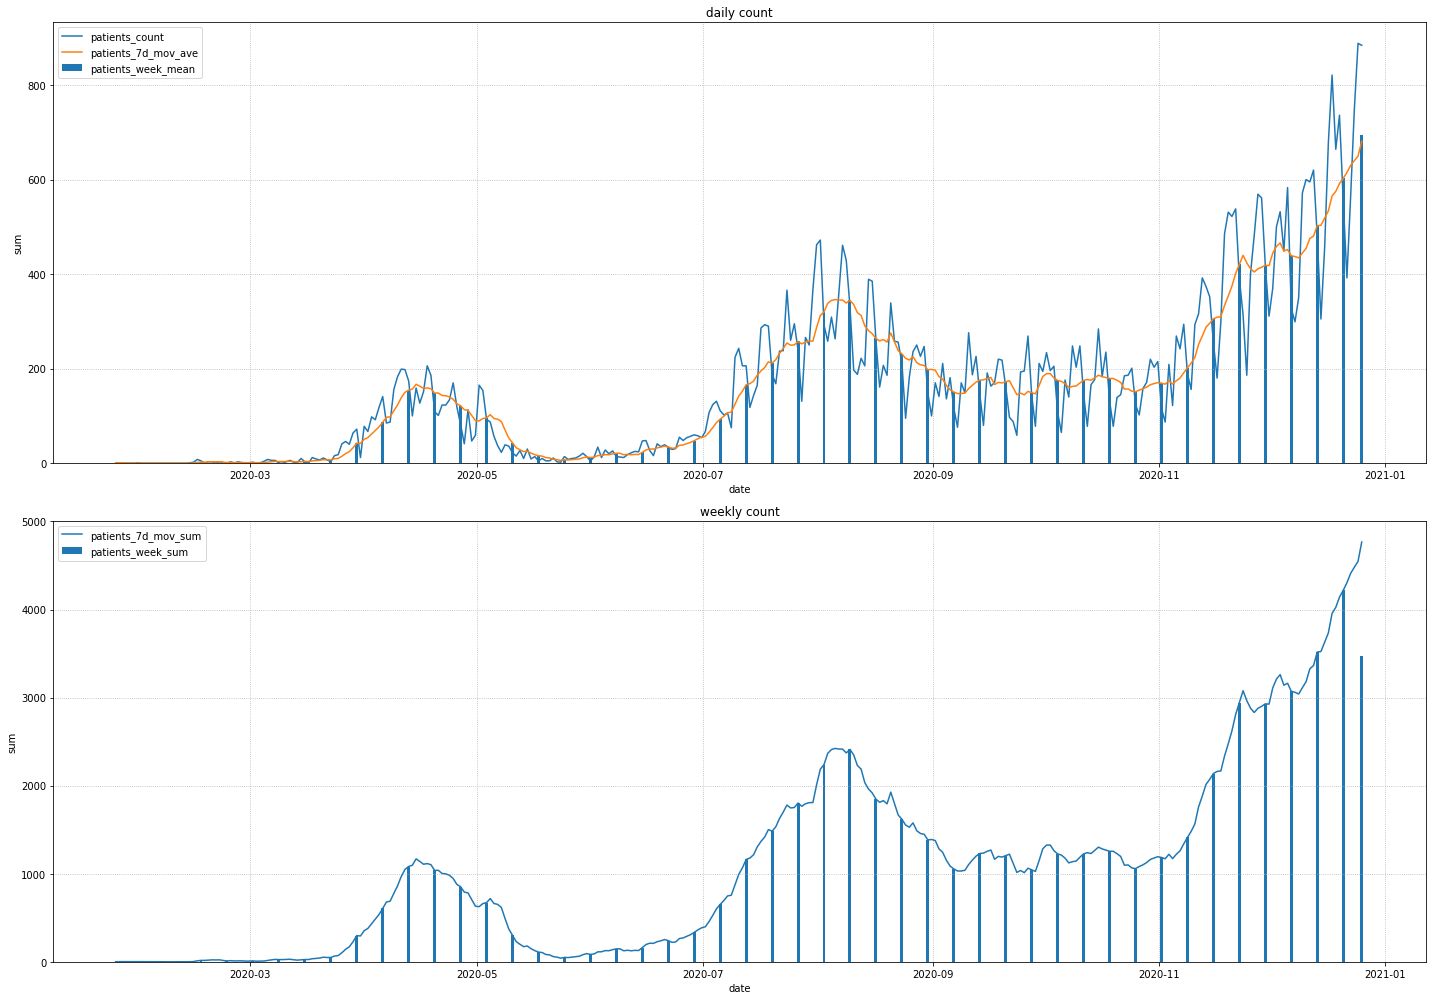

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [15]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [16]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [17]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [18]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [19]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
322,1.607674e+09,2020,12,11,1,0,0,0,0,0,0,322,0,248,525,459.428571,3216.0,0,0.0,0.0,595,475.285714,3327.0
323,1.607760e+09,2020,12,12,0,0,1,0,0,0,0,323,0,249,679,479.142857,3354.0,0,0.0,0.0,620,480.571429,3364.0
324,1.607846e+09,2020,12,13,0,0,0,1,0,0,0,324,0,250,497,491.142857,3438.0,0,0.0,0.0,480,502.428571,3517.0
325,1.607933e+09,2020,12,14,0,1,0,0,0,0,0,325,0,251,573,514.000000,3598.0,0,0.0,0.0,305,503.285714,3523.0
326,1.608019e+09,2020,12,15,0,0,0,0,0,1,0,326,0,252,438,517.428571,3622.0,0,0.0,0.0,457,518.428571,3629.0
327,1.608106e+09,2020,12,16,0,0,0,0,0,0,1,327,0,253,517,522.857143,3660.0,0,0.0,0.0,678,533.571429,3735.0
328,1.608192e+09,2020,12,17,0,0,0,0,1,0,0,328,0,254,617,549.428571,3846.0,0,0.0,0.0,821,565.142857,3956.0
329,1.608278e+09,2020,12,18,1,0,0,0,0,0,0,329,0,255,583,557.714286,3904.0,0,0.0,0.0,664,575.000000,4025.0
330,1.608365e+09,2020,12,19,0,0,1,0,0,0,0,330,0,256,738,566.142857,3963.0,0,0.0,0.0,736,591.571429,4141.0
331,1.608451e+09,2020,12,20,0,0,0,1,0,0,0,331,0,257,581,578.142857,4047.0,0,0.0,0.0,556,602.428571,4217.0


In [20]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            337 non-null    float64
 1   year                 337 non-null    int64  
 2   month                337 non-null    int64  
 3   day                  337 non-null    int64  
 4   Fri                  337 non-null    uint8  
 5   Mon                  337 non-null    uint8  
 6   Sat                  337 non-null    uint8  
 7   Sun                  337 non-null    uint8  
 8   Thu                  337 non-null    uint8  
 9   Tue                  337 non-null    uint8  
 10  Wed                  337 non-null    uint8  
 11  passed               337 non-null    int64  
 12  emergency            337 non-null    int64  
 13  em_passed            337 non-null    int64  
 14  contacts_count       337 non-null    int64  
 15  contacts_7d_mov_ave  337 non-null    flo

In [21]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.370000e+02,337.0,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,1.594368e+09,2020.0,6.792285,15.786350,0.145401,0.142433,0.142433,0.142433,0.142433,0.142433,0.142433,168.000000,0.145401,102.234421,740.489614,736.359404,5154.504451,1093.528190,1093.528190,7654.697329,162.913947,156.237940,1093.617211
std,8.417758e+06,0.0,3.205956,8.811623,0.353028,0.350014,0.350014,0.350014,0.350014,0.350014,0.350014,97.427751,0.353028,86.378742,467.415749,455.300278,3187.120306,856.693304,716.611728,5016.282097,172.380864,151.704824,1061.983555
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.587110e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.000000,0.000000,10.000000,445.000000,455.714286,3190.000000,271.000000,779.000000,5453.000000,16.000000,18.142857,127.000000
50%,1.594368e+09,2020.0,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,94.000000,590.000000,601.285714,4209.000000,1138.000000,1094.428571,7661.000000,124.000000,149.285714,1045.000000
75%,1.601626e+09,2020.0,10.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,252.000000,0.000000,178.000000,836.000000,875.571429,6129.000000,1710.000000,1622.571429,11358.000000,235.000000,214.428571,1501.000000
max,1.608883e+09,2020.0,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,336.000000,1.000000,262.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,888.000000,681.000000,4767.000000


In [22]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,NaN,0.995919,0.003023,-5.596364e-18,-0.002095,-0.010473,-0.006284,0.010473,0.002095,0.006284,1.000000e+00,-0.296799,0.986923,-0.132404,-0.101622,-0.101616,-0.115700,-0.091189,-0.091189,0.748884,0.806571,0.806612
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.959190e-01,NaN,1.000000,-0.087122,-2.161441e-03,-0.002731,-0.010688,-0.005383,0.010530,0.002574,0.007878,9.959190e-01,-0.294050,0.982107,-0.129008,-0.099580,-0.099573,-0.114226,-0.087341,-0.087341,0.745166,0.802653,0.802698
day,3.023003e-03,NaN,-0.087122,1.000000,2.436713e-02,0.007001,0.002176,-0.009404,-0.000719,-0.005544,-0.018088,3.023003e-03,-0.004335,0.006299,-0.009376,0.006070,0.006065,0.006793,-0.017371,-0.017371,0.009667,0.009031,0.008981
Fri,-5.596364e-18,NaN,-0.002161,0.024367,1.000000e+00,-0.168102,-0.168102,-0.168102,-0.168102,-0.168102,-0.168102,2.459340e-18,-0.002976,0.002490,-0.027938,-0.008005,-0.008004,0.044471,-0.011027,-0.011027,0.090193,0.010466,0.010437
Mon,-2.094616e-03,NaN,-0.002731,0.007001,-1.681022e-01,1.000000,-0.166090,-0.166090,-0.166090,-0.166090,-0.166090,-2.094616e-03,0.000500,-0.002289,0.048999,0.000457,0.000458,0.215687,0.001854,0.001854,-0.155522,-0.005408,-0.005402
Sat,-1.047308e-02,NaN,-0.010688,0.002176,-1.681022e-01,-0.166090,1.000000,-0.166090,-0.166090,-0.166090,-0.166090,-1.047308e-02,0.000500,-0.009573,0.044633,-0.002681,-0.002679,-0.245629,0.001854,0.001854,0.081791,-0.012971,-0.012992
Sun,-6.283847e-03,NaN,-0.005383,-0.009404,-1.681022e-01,-0.166090,-0.166090,1.000000,-0.166090,-0.166090,-0.166090,-6.283847e-03,0.000500,-0.005931,-0.011706,-0.001131,-0.001129,-0.226185,0.001854,0.001854,-0.056227,-0.008538,-0.008540
Thu,1.047308e-02,NaN,0.010530,-0.000719,-1.681022e-01,-0.166090,-0.166090,-0.166090,1.000000,-0.166090,-0.166090,1.047308e-02,0.000500,0.008835,-0.006067,0.005678,0.005679,0.064026,0.001854,0.001854,0.105073,0.012187,0.012205
Tue,2.094616e-03,NaN,0.002574,-0.005544,-1.681022e-01,-0.166090,-0.166090,-0.166090,-0.166090,1.000000,-0.166090,2.094616e-03,0.000500,0.001353,-0.030608,0.001980,0.001982,0.086983,0.001854,0.001854,-0.055832,-0.000906,-0.000894


---

In [23]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [24]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,1.608538e+09,0,1,0,0,0,0,0,332,0,258,595,0,392,614.857143,4304.0
333,1.608624e+09,0,0,0,0,0,1,0,333,0,259,571,0,563,630.000000,4410.0
334,1.608710e+09,0,0,0,0,0,0,1,334,0,260,667,0,748,640.000000,4480.0
335,1.608797e+09,0,0,0,0,1,0,0,335,0,261,719,0,888,649.571429,4547.0


In [25]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
332,1.608538e+09,332,0,392,614.857143,4304.0
333,1.608624e+09,333,0,563,630.000000,4410.0
334,1.608710e+09,334,0,748,640.000000,4480.0
335,1.608797e+09,335,0,888,649.571429,4547.0


In [26]:
import seaborn as sns

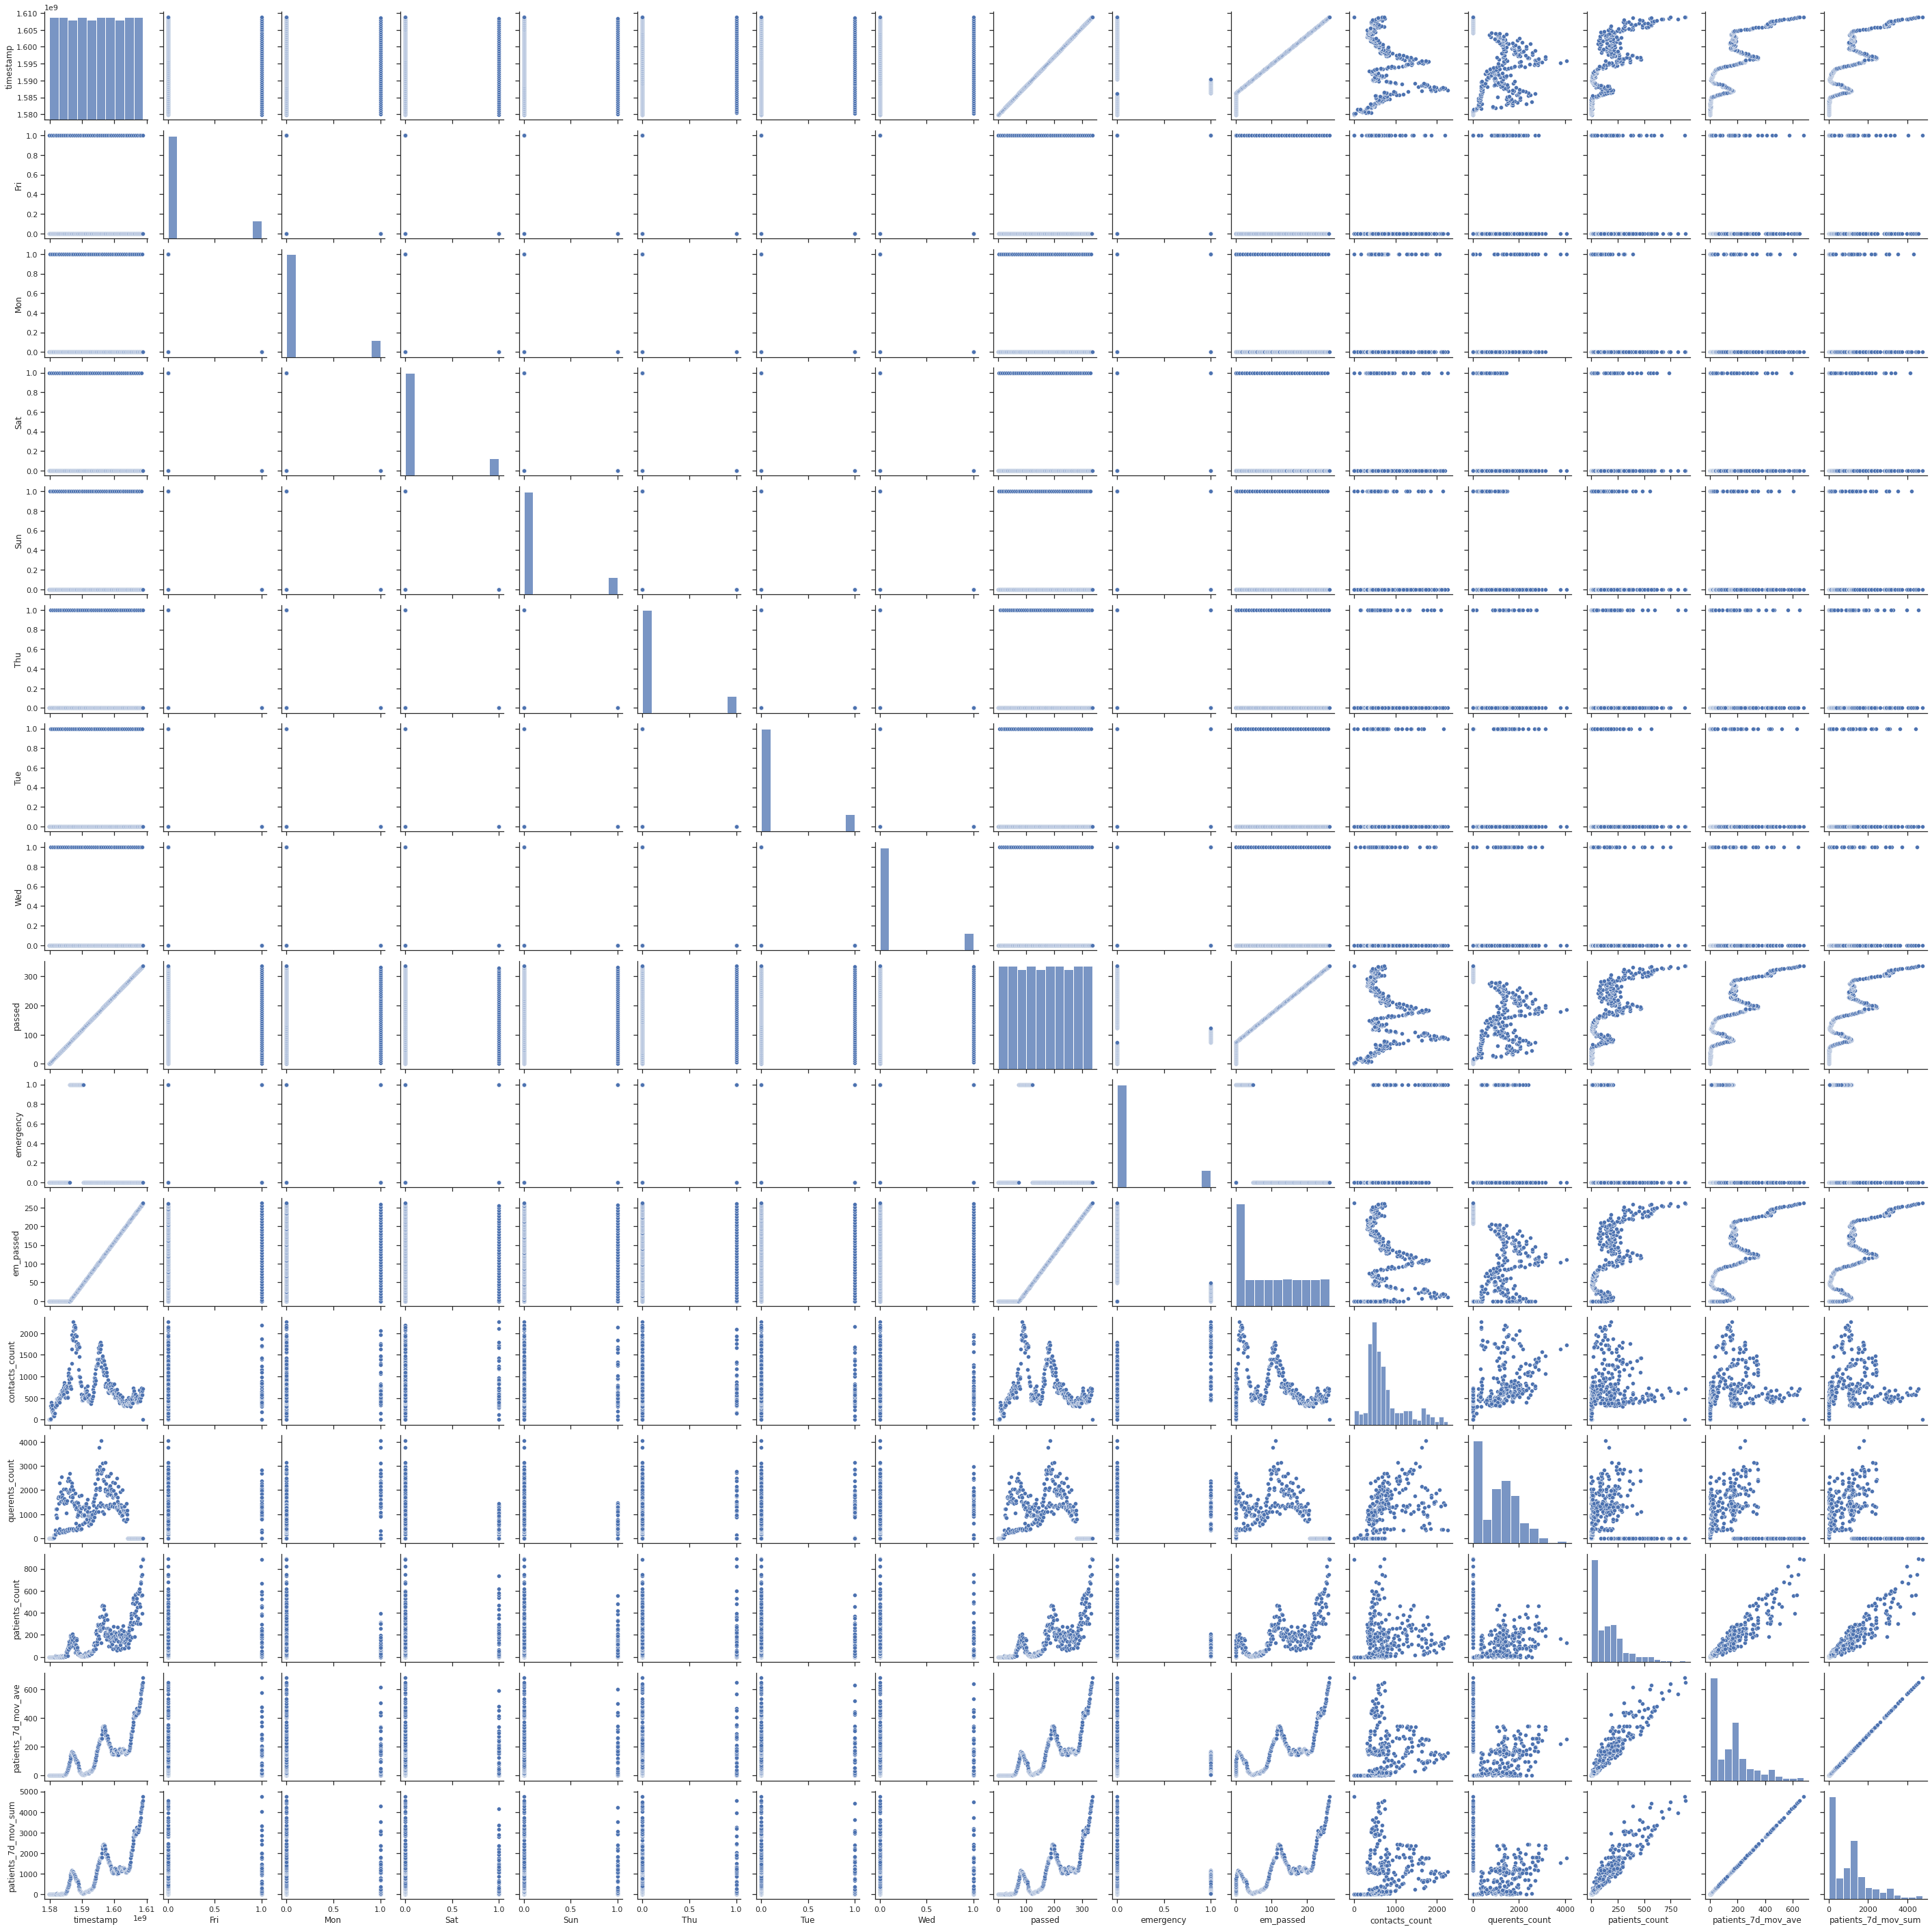

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

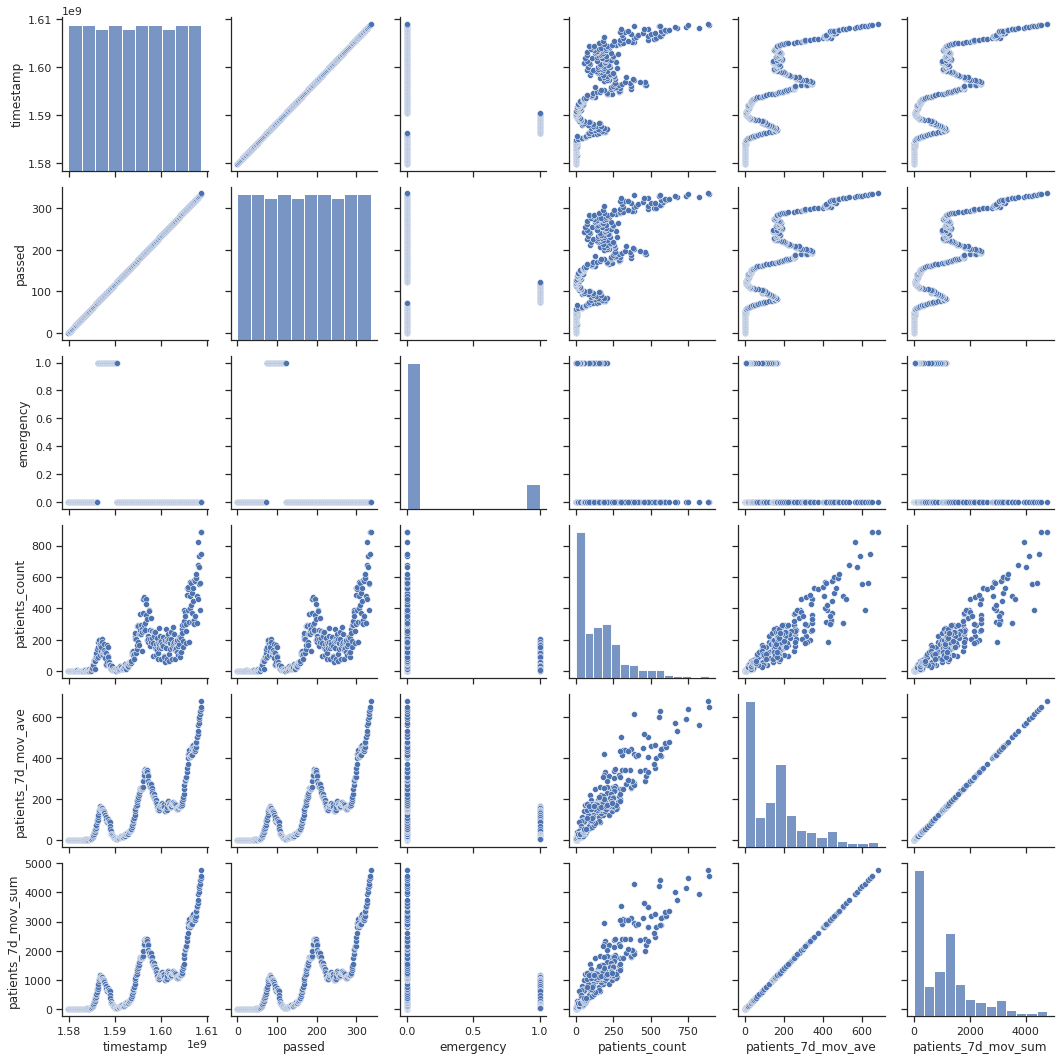

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.6.9
